# Training an image classifier 

## Steps
1. Load and normalizing the Edible Wild Plants training and test datasets
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


In [4]:
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

## Load and normalizing dataset

In [1]:
import os
import numpy as np
from torchvision.datasets.folder import ImageFolder, default_loader
from torchvision.datasets.utils import download_url, check_integrity

class EdibleWildPlantsDataset(ImageFolder):
    """
    The 'Edible Wild Plants' dataset from kaggle.

    https://www.kaggle.com/gverzea/edible-wild-plants

    Args:
        root: the location where to store the dataset
        suffix: path to the train/valid/sample dataset. See folder structure.
        transform (callable, optional): A function/transform that takes in
            an PIL image and returns a transformed version.
            E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that
            takes in the target and transforms it.
        loader: A function to load an image given its path.
        download: if ``True``, download the data.


    The folder structure of the dataset is as follows::

...

    """
    url = "https://www.kaggle.com/gverzea/edible-wild-plants/downloads/edible-wild-plants.zip/5"
    filename = "edible-wild-plants.zip"
    checksum = "22934d7bb30c6e1ebbb805fd186afd6f"

    def __init__(self,
                 root: str,
                 suffix: str,
                 transform=None,
                 target_transform=None,
                 loader=default_loader,
                 download=False):
        self.root = os.path.expanduser(root)

        if download:
            self._download()
            self._extract()

        #if not self._check_integrity():
        #    raise RuntimeError("Dataset not found or corrupted. "
        #                       "You can use download=True to download it")

        path = os.path.join(self.root, suffix)
        print(f"Loading data from {path}.")
        assert os.path.isdir(path), f"'{suffix}' is not valid."

        super().__init__(path, transform, target_transform, loader)
    
    #def __getitem__(self, idx):
        #item = super().__getitem__(idx)
        #return (item[0], np.ndarray(item[1]))

    def _download(self):
        if self._check_integrity():
            print("Dataset already downloaded and verified.")
            return

        root = self.root
        print("Downloading dataset... (this might take a while)")
        download_url(self.url, root, self.filename, self.checksum)

    def _extract(self):
        import zipfile
        path_to_zip = os.path.join(self.root, self.filename)
        with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
            zip_ref.extractall(self.root)
        with zipfile.ZipFile(os.path.join(self.root, 'datasets.zip'), 'r') as zip_ref:
            zip_ref.extractall(self.root)

    def _check_integrity(self):
        
        path_to_zip = os.path.join(self.root, self.filename)
        print (path_to_zip)
        return check_integrity(path_to_zip, self.checksum)

In [13]:
from torchvision import transforms

transform = {'train': transforms.Compose([transforms.Resize(256),
                                          transforms.RandomCrop(256),
                                          transforms.ToTensor()
                                          ]),
             'test': transforms.Compose([transforms.Resize(256),
                                          transforms.RandomCrop(256),
                                          transforms.ToTensor()
                                          ])
            }

train_dataset = EdibleWildPlantsDataset('../data', 'dataset', transform=transform['train'], download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

test_dataset = EdibleWildPlantsDataset('../data', 'dataset-test', transform=transform['test'])

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

classes = train_dataset.classes
#classes

../data/edible-wild-plants.zip
Dataset already downloaded and verified.


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f1f7c594208>>
Traceback (most recent call last):
  File "/home/caillou/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/caillou/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/caillou/anaconda3/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/home/caillou/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/caillou/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


../data/edible-wild-plants.zip
Loading data from ../data/dataset.
../data/edible-wild-plants.zip
Loading data from ../data/dataset-test.


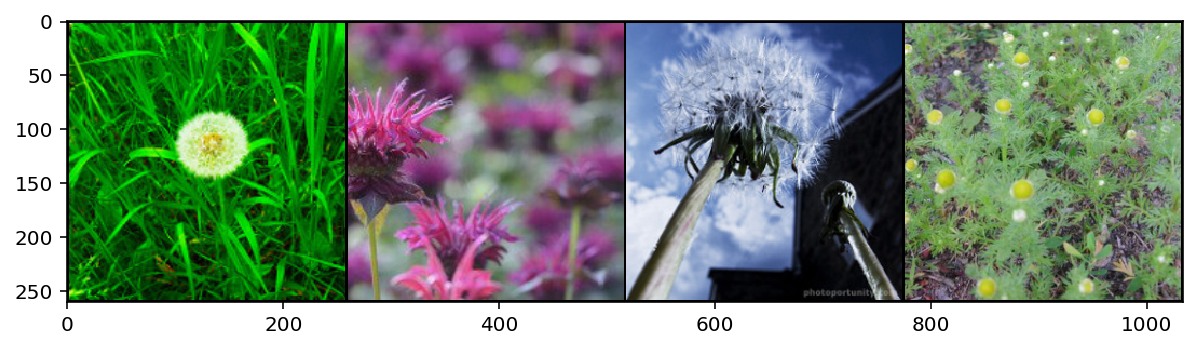

Dandellion   -    Wild Bee Balm   -    Dandellion   -    Pineapple Weed


In [116]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format ='retina'
#plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
# functions to show an image

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #print (npimg.shape)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
#print (images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('   -    '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define a Convolutional Neural Network

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 *61, 2000)
        self.fc2 = nn.Linear(2000, 500)
        self.fc3 = nn.Linear(500, 62)

    def forward(self, x):
        #print(x.size())
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = x.view(-1, 16 * 61 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
#net = torch.load('../model.pt')

## Define a loss function and an optimizer

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network on the training data

In [12]:
epochs = 1
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print (labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f1f7c13a5f8>>
Traceback (most recent call last):
  File "/home/caillou/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/caillou/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/caillou/anaconda3/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f1f7c214978>>
Traceback (most recent call last):
  File "/home/caillou/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/caillou/

OSError: Traceback (most recent call last):
  File "/home/caillou/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/caillou/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/caillou/anaconda3/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 101, in __getitem__
    sample = self.loader(path)
  File "/home/caillou/anaconda3/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 147, in default_loader
    return pil_loader(path)
  File "/home/caillou/anaconda3/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 129, in pil_loader
    img = Image.open(f)
  File "/home/caillou/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2687, in open
    % (filename if filename else fp))
OSError: cannot identify image file <_io.BufferedReader name='../data/dataset/Cattail/Cattail2.jpg'>


In [101]:
torch.save(net, '../model.pt')

/home/caillou/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Test the network on the test data

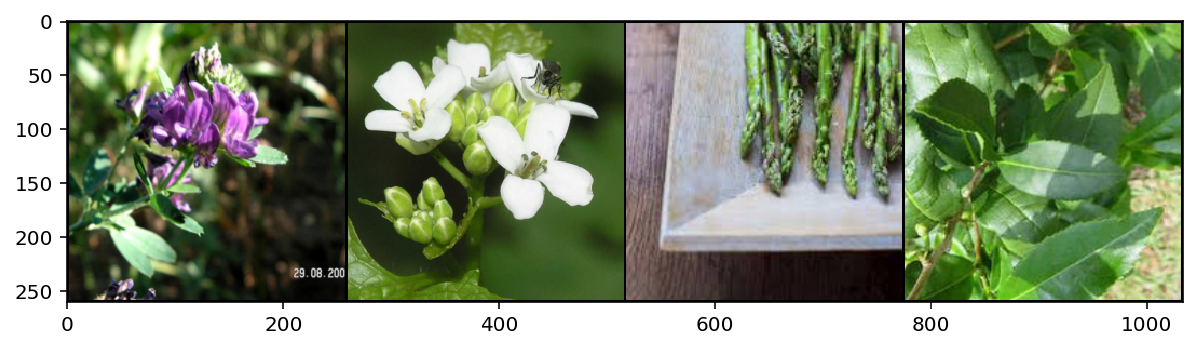

GroundTruth:  Alfalfa -  Garlic Mustard -  Asparagus -  Tea Plant


In [127]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('GroundTruth: ',' -  '.join('%5s' % classes[labels[j]] for j in range(4)))

In [128]:
outputs = net(images)

In [133]:
_, predicted = torch.max(outputs, 1)
predicted

tensor([49, 49, 49, 49])

In [131]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  Shepherds Purse Shepherds Purse Shepherds Purse Shepherds Purse


In [136]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])
tensor([49, 49, 49, 49])


In [137]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[[[ 0.0426, -0.0882, -0.0645, -0.0176,  0.0628],
          [ 0.0140, -0.1008, -0.0335,  0.0676, -0.0283],
          [-0.0647,  0.0924, -0.0975, -0.0839,  0.0643],
          [ 0.0922, -0.1122,  0.0190, -0.0808,  0.0728],
          [-0.0576,  0.0248, -0.0147,  0.0903, -0.0120]],

         [[-0.0649, -0.0903, -0.0276, -0.0192, -0.0788],
          [ 0.0602, -0.0928, -0.0287, -0.1096, -0.0942],
          [-0.0701,  0.0514,  0.0603,  0.0338,  0.0819],
          [ 0.0767, -0.1077,  0.0515, -0.0448, -0.0404],
          [-0.0633, -0.0687, -0.1008, -0.0233,  0.0715]],

         [[ 0.0262, -0.0679,  0.0017,  0.0825, -0.0467],
          [-0.1042, -0.0114, -0.0097, -0.0735,  0.0455],
          [ 0.0058, -0.0612, -0.0806, -0.0380, -0.0297],
          [-0.0618,  0.0752, -0.0646,  0.1132, -0.0592],
          [-0.0511, -0.0538, -0.0145, -0.0685, -0.1040]]],


        [[[ 0.0013, -0.0560, -0.0920, -0.0006, -0.0059],
          [ 0.0235, -0.0376, -0.0558, -0.0237, -0.0304],
 